# Individual-level characteristics of peer pressure model

In [2]:
import plotly.io as pio
pio.renderers.default='notebook'

In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sympy import Symbol, diff, lambdify, solve, nsolve, exp
import datetime

from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import kurtosistest
from scipy.stats import skewtest
from scipy.stats import bernoulli
from sklearn.metrics import mean_absolute_error

In [4]:
#turning a list into an array is much faster with cython than it is with numpy

%load_ext cython

In [5]:
%%cython

cimport cython
import numpy as np

@cython.boundscheck(False)
cpdef to_array(list inp):
    cdef long[:] arr = np.zeros(len(inp), dtype=long)
    cdef Py_ssize_t idx
    for idx in range(len(inp)):
        arr[idx] = inp[idx]
    return np.asarray(arr)

In [15]:
def run_simulation(G
                   ,n_iterations
                   ,attitude_m
                   ,attitude_sd
                   ,fraction_a
                   ,a_bilateral
                   ,epsilon_sd):
    
    '''Simulates the defined peer pressure process over an existing network graph
    
    Args:
        G (networkx graph): Undirected graph defining peer relationships in a mock society
        n_iterations (int): Number of times to iterate through the behavior updating process
        attitude_m (float): Mean of attitude distribution
        attitude_sd (float): Scale of attitude distribution
        fraction_a (float): Bernoulli parameter for setting apathy switch to 0 or 1 for each person
        a_bilateral (bool): switch for bilateral apathy, as opposed to unilateral
        epsilon_sd (float): standard deviation of random factor

    Returns:
        Dictionary of form {epoch -> (mean resultant behavior)}
    '''
    population = len(G)
    attitudes = np.random.normal(loc = attitude_m
                                 ,scale = attitude_sd
                                 , size = population)
    for j in G.nodes:
        G.nodes[j]['behavior'] = 0

    #before here 
    apathies = bernoulli.rvs(fraction_a, size = population)
    apathy_dict = {i : apathies[i] for i in range(len(apathies))}
    nx.set_node_attributes(G, apathy_dict, "apathy")
        
    node_list = list(G.nodes)
        
    rands = np.random.normal(scale = epsilon_sd,size = (n_iterations,population))
    
    neighbors = [[G.nodes[j] for j in G.neighbors(n)] for n in node_list]
    neighbor_node_list = [n for v,n in zip(neighbors,node_list) for x in v]
    labels = to_array(neighbor_node_list) #gets used later
    
    for i in range(n_iterations):
                
        if a_bilateral:
            neighbor_behaviors = [x['behavior'] if not x['apathy'] else 0 \
                      for v in neighbors for x in v ]
        else:
            neighbor_behaviors = [x['behavior'] if not (x['apathy'] and not x['behavior'] ==1) else 0 \
                                  for v in neighbors for x in v ]

        average_neighbor_behaviors = clever_average(neighbor_behaviors, labels)
        
        new_behavior = np.sign(average_neighbor_behaviors + attitudes + rands[i])
        
        for j, v in zip(G.nodes, new_behavior):
            G.nodes[j]['behavior'] = v
            
    return G, attitudes

#this function is adapted from Vlad Feinberg, at https://vladfeinberg.com/2021/01/07/vectorizing-ragged-arrays.html
#the purpose is to do a more efficient 'jagged mean' via clever vectorization
def clever_average(Xz, labels):
    d = np.diff(labels, prepend=-1) # binary mask where labels change
    
    pos = np.flatnonzero(d) # indices where labels change
    pos = np.append(pos, len(Xz))
    
    Xz = np.concatenate((np.zeros_like(Xz[0:1]), Xz), axis=0)
    Xsums = np.cumsum(Xz, axis=0)

    # reduce by taking differences of accumulations exactly at the
    # endpoints for cluster indices, using pos array
    Xsums = np.diff(Xsums[pos], axis=0)
    counts = np.diff(pos)

    return Xsums / np.maximum(counts, 1)

To study inviduals under peer pressure, we will run a balanced (m = 0) simulation on a very large Barabasi-Albert graph. That will give us many data points

In [16]:
G = nx.generators.random_graphs.barabasi_albert_graph(1000000, 8, seed = 0)
result, initial_attitudes = run_simulation(G = G
                   ,n_iterations = 20
                   ,attitude_m = 0
                   ,attitude_sd = 1
                   ,fraction_a = 0
                   ,a_bilateral = False
                   ,epsilon_sd = 0.17)

In [22]:
behaviors = [G.nodes[n]['behavior'] for n in G]
average_neighbor_behavior = [np.mean([G.nodes[i]['behavior'] for i in G.neighbors(n)]) for n in G.nodes]
degrees = [G.degree[n] for n in G.nodes]
result_df = pd.DataFrame({'attitude' : initial_attitudes
                          , 'behavior' : behaviors
                          , 'average_neighbor_behavior' : average_neighbor_behavior
                          , 'degree' : degrees})


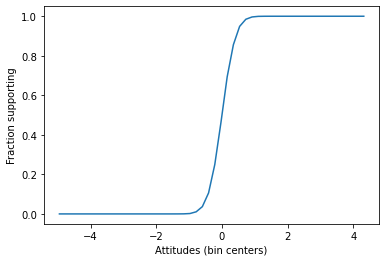

In [57]:
attitude_cat = pd.cut(result_df['attitude'], bins = 50)
result_df.loc[:,'attitude_cat'] = [(x.left+x.right)/2 for x in attitude_cat]
bin_series = (result_df.groupby('attitude_cat')['behavior'].mean()+1)/2
plt.plot(bin_series)

plt.xlabel('Attitudes (bin centers)')
plt.ylabel('Fraction supporting')
plt.show()

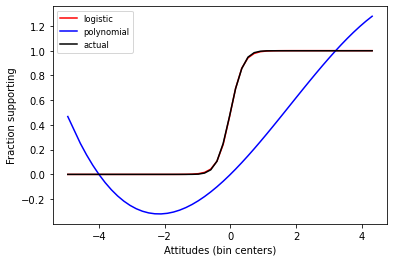

In [58]:
def logifunc(x,A,k, off):
    return A / (1 + np.exp(-k*(x)))+off

def polyfunc(x,a,b,c):
    return a*x**3 + b*x**2 + c*x**1

logi_popt, logi_pcov = curve_fit(logifunc, bin_series.index, bin_series, p0=[9, 1, 0])

poly_popt, poly_pcov = curve_fit(polyfunc, bin_series.index, bin_series, p0=[0,0,0])

plt.plot(bin_series.index, logifunc(bin_series.index,*logi_popt), color = 'red', label = 'logistic')
plt.plot(bin_series.index, polyfunc(bin_series.index,*poly_popt), color = 'blue', label = 'polynomial')
plt.plot(bin_series.index, bin_series, color = 'black', label = 'actual')

plt.xlabel('Attitudes (bin centers)')
plt.ylabel('Fraction supporting')
plt.legend(fontsize = 'small', loc = 'upper left')

plt.show()

This graph is clearly logistic! This tells us that a normal distributions of behaviors leads to a logistic distribution of behaviors

More to part 2 coming soon :) 